In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# read in train and test data

train_data = pd.read_csv('train.csv')

test_data = pd.read_csv('test.csv')

In [3]:
# train head

train_data.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


## Initial Analysis of Training Data

In [2]:
import nltk
import string
import re
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from scipy import stats

In [5]:
# sample excerpt first row

train_data.excerpt[0]

'When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.\nThe floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.\nAt each end of the room, on the wall, hung a beautiful bear-skin rug.\nThese rugs were for prizes, one for the girls and one for the boys. And this was the game.\nThe girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.\nThis would have been an easy matter, but each traveller was obliged to wear snowshoes.'

In [6]:
# basic descriptives of data

def desc_stats(data):
    
    print('Shape:', data.shape, '\n')
    print('Info:', data.info(),'\n')
    print('Null Analysis:\n', data.isnull().sum(), '\n')
    
    return data.describe()

desc_stats(train_data)

Shape: (2834, 6) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2834 entries, 0 to 2833
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              2834 non-null   object 
 1   url_legal       830 non-null    object 
 2   license         830 non-null    object 
 3   excerpt         2834 non-null   object 
 4   target          2834 non-null   float64
 5   standard_error  2834 non-null   float64
dtypes: float64(2), object(4)
memory usage: 133.0+ KB
Info: None 

Null Analysis:
 id                   0
url_legal         2004
license           2004
excerpt              0
target               0
standard_error       0
dtype: int64 



,target,standard_error
count,2834.000000,2834.000000
mean,-0.959319,0.491435
std,1.033579,0.034818
min,-3.676268,0.000000
25%,-1.690320,0.468543
50%,-0.912190,0.484721
75%,-0.202540,0.506268
max,1.711390,0.649671


In [13]:
# 709 data points above 75th percentile

train_data.target.loc[train_data.target >= -0.202540]

4       0.247197
14      0.245806
15     -0.188186
20      0.281178
21      0.278203
          ...   
2828    0.608108
2829    1.711390
2830    0.189476
2831    0.255209
2833    0.300779
Name: target, Length: 709, dtype: float64

In [15]:
# character length stats of excerpts
lengths = []
for i in train_data['excerpt']:
    lengths.append(len(i))

average_len = sum(lengths)/len(lengths)

print('Average excerpt length: ', average_len)
print('Median excerpt length: ', np.median(lengths))
print('Mode excerpt length: ', float(stats.mode(lengths)[0]))
print('Standard Dev excerpt length: ', np.std(lengths))
print('Variance excerpt length: ', np.std(lengths)**2)

Average excerpt length:  971.7328863796754
Median excerpt length:  971.0
Mode excerpt length:  936.0
Standard Dev excerpt length:  117.23688809620975
Variance excerpt length:  13744.487930483208


[('the', 30098), ('and', 16142), ('of', 15208), ('to', 12647), ('a', 11374), ('in', 8179), ('was', 5664), ('is', 5149), ('that', 4958), ('as', 3504), ('he', 3489), ('for', 3477), ('with', 3442), ('his', 3208), ('it', 3157), ('The', 2944), ('on', 2781), ('had', 2766), ('are', 2640), ('be', 2397)]


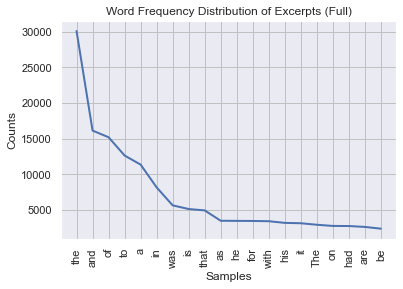

In [21]:
# Word Freq Dist of excerpts

from nltk.probability import FreqDist

corpus = []

for text in train_data['excerpt']:
    for word in text.split(' '):
        corpus.append(word)
    #corpus.append(i)

fdist = FreqDist(corpus)

print(fdist.most_common(20))

# accompanying visual

plt.title('Word Frequency Distribution of Excerpts (Full)')
fdist.plot(20)
plt.show()

## Cleaning Training Data

In [50]:
# clean/process corpus

# Function to streamline NLP Process

def nlp(df, text):
    # Load string
    # raw_data = pd.read_csv(file + '.csv')
    
    df['dummy'] = df[text].astype(str)
    # Convert to lowercase
    df['dummy'] = [post.lower() for post in df['dummy']]

    # Word & Sentence Tokenization
    token_post = [word_tokenize(post) for post in df['dummy']]

    #sent_token = [sent_tokenize(post) for post in df['text']]
    
    # Remove Punctuation
    reg = re.compile('(@[a-z0-9]+)|([^0-9a-z \t])|(\w+:\/\/\S+)')

    no_punc = []

    for filt in token_post:
        review = []
        for token in filt:
            new_token = reg.sub(u'', token)
            if not new_token == u'':
                review.append(new_token)
        no_punc.append(review)
        
    # Remove Stopwords
    no_stop = []

    for post in no_punc:
        new_term_vector = []
        for word in post:
            if not word in stopwords.words('english'):
                new_term_vector.append(word)

        no_stop.append(new_term_vector)
        
    # Stemming & Lemmatization
    pstem = PorterStemmer()
    wlem = WordNetLemmatizer()

    preproc_text = []

    for text in no_stop:
        final_text = []
        for word in text:
            pstem.stem(word)
            final_text.append(wlem.lemmatize(word))

        preproc_text.append(final_text)
        
    # create final data set
    #data = df.copy()

    new_col = pd.Series(preproc_text)
    df['proc_ex'] = new_col
    df.drop('dummy', axis=1, inplace=True)
    return df

proc_data = nlp(train_data, 'excerpt')

In [51]:
proc_data.head()

,id,url_legal,license,excerpt,target,standard_error,proc_ex
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,"[young, people, returned, ballroom, presented,..."
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,"[dinner, time, mr, fayre, somewhat, silent, ey..."
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,"[roger, predicted, snow, departed, quickly, ca..."
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,"[outside, palace, great, garden, walled, round..."
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,"[upon, time, three, bear, lived, together, hou..."


In [52]:
#proc_data.drop('processed excerpts', axis=1, inplace=True)
#proc_data.rename({'processed_excerpts':'proc_ex'}, inplace=True)


KeyError: "['processed excerpts'] not found in axis"

In [2]:
# save processed data output

proc_data.to_csv('proc_train_data.csv', index=False)

NameError: name 'proc_data' is not defined

[('one', 1975), ('would', 1161), ('little', 1135), ('said', 1111), ('time', 1065), ('could', 943), ('day', 824), ('like', 808), ('two', 782), ('made', 770), ('people', 758), ('great', 696), ('water', 682), ('many', 682), ('way', 673), ('first', 671), ('called', 636), ('year', 627), ('also', 609), ('came', 608)]


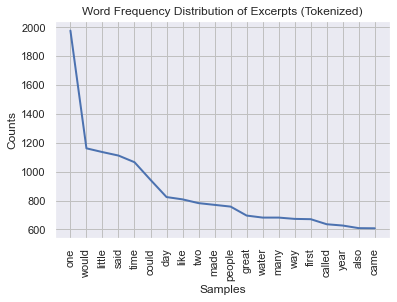

In [54]:
# Word Freq Dist of tokenized excerpts

from nltk.probability import FreqDist

corpus = []

for text in proc_data['proc_ex']:
    for word in text:
        corpus.append(word)
    #corpus.append(i)

fdist = FreqDist(corpus)

print(fdist.most_common(20))

# accompanying visual

plt.title('Word Frequency Distribution of Excerpts (Tokenized)')
fdist.plot(20)
plt.show()

## Feature Engineering

In [4]:
# TODO

# Feature Engineering: Do verbs, nouns, and Adjectives correlate with target?
# - find number of verbs, nouns, adj, etc
# use nltk.post_tag to find the num of verbs, nouns, etc in excerpt
# 

In [5]:
# load saved data

data = pd.read_csv('proc_train_data.csv')

data.head()

,id,url_legal,license,excerpt,target,standard_error,proc_ex
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,"['young', 'people', 'returned', 'ballroom', 'p..."
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,"['dinner', 'time', 'mr', 'fayre', 'somewhat', ..."
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,"['roger', 'predicted', 'snow', 'departed', 'qu..."
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,"['outside', 'palace', 'great', 'garden', 'wall..."
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,"['upon', 'time', 'three', 'bear', 'lived', 'to..."


In [7]:
data.proc_ex = data.proc_ex.astype('category')

for i in data.proc_ex:
    
    data['proc_ex']

In [8]:
result = nltk.pos_tag(data['proc_ex'].head(), tagset='universal')

result = [i for i in result]

result

[("['young', 'people', 'returned', 'ballroom', 'presented', 'decidedly', 'changed', 'appearance', 'instead', 'interior', 'scene', 'winter', 'landscape', 'floor', 'covered', 'snowwhite', 'canvas', 'laid', 'smoothly', 'rumpled', 'bump', 'hillock', 'like', 'real', 'snow', 'field', 'numerous', 'palm', 'evergreen', 'decorated', 'room', 'powdered', 'flour', 'strewn', 'tuft', 'cotton', 'like', 'snow', 'also', 'diamond', 'dust', 'lightly', 'sprinkled', 'glittering', 'crystal', 'icicle', 'hung', 'branch', 'end', 'room', 'wall', 'hung', 'beautiful', 'bearskin', 'rug', 'rug', 'prize', 'one', 'girl', 'one', 'boy', 'game', 'girl', 'gathered', 'one', 'end', 'room', 'boy', 'one', 'end', 'called', 'north', 'pole', 'south', 'pole', 'player', 'given', 'small', 'flag', 'plant', 'reaching', 'pole', 'would', 'easy', 'matter', 'traveller', 'obliged', 'wear', 'snowshoe']",
  'ADJ'),
 ("['dinner', 'time', 'mr', 'fayre', 'somewhat', 'silent', 'eye', 'resting', 'dolly', 'wistful', 'uncertain', 'expression', 'wa

In [9]:
# get tags from tokenized excerpts

for i in data['proc_ex'][:10]:
    print(nltk.pos_tag(eval(i), tagset='universal'),'\n')

[('young', 'ADJ'), ('people', 'NOUN'), ('returned', 'VERB'), ('ballroom', 'ADV'), ('presented', 'VERB'), ('decidedly', 'ADV'), ('changed', 'VERB'), ('appearance', 'NOUN'), ('instead', 'ADV'), ('interior', 'ADJ'), ('scene', 'NOUN'), ('winter', 'NOUN'), ('landscape', 'NOUN'), ('floor', 'NOUN'), ('covered', 'VERB'), ('snowwhite', 'ADJ'), ('canvas', 'NOUN'), ('laid', 'VERB'), ('smoothly', 'ADV'), ('rumpled', 'VERB'), ('bump', 'NOUN'), ('hillock', 'NOUN'), ('like', 'ADP'), ('real', 'ADJ'), ('snow', 'ADJ'), ('field', 'NOUN'), ('numerous', 'ADJ'), ('palm', 'NOUN'), ('evergreen', 'NOUN'), ('decorated', 'VERB'), ('room', 'NOUN'), ('powdered', 'VERB'), ('flour', 'ADJ'), ('strewn', 'NOUN'), ('tuft', 'ADJ'), ('cotton', 'NOUN'), ('like', 'ADP'), ('snow', 'NOUN'), ('also', 'ADV'), ('diamond', 'VERB'), ('dust', 'NOUN'), ('lightly', 'ADV'), ('sprinkled', 'VERB'), ('glittering', 'VERB'), ('crystal', 'ADJ'), ('icicle', 'NOUN'), ('hung', 'NOUN'), ('branch', 'ADJ'), ('end', 'NOUN'), ('room', 'NOUN'), ('wa

In [10]:
# get tags from tokenized excerpts


pos_words = [nltk.pos_tag(eval(i), tagset='universal') for i in data['proc_ex']]

pos_words[:5]

[[('young', 'ADJ'),
  ('people', 'NOUN'),
  ('returned', 'VERB'),
  ('ballroom', 'ADV'),
  ('presented', 'VERB'),
  ('decidedly', 'ADV'),
  ('changed', 'VERB'),
  ('appearance', 'NOUN'),
  ('instead', 'ADV'),
  ('interior', 'ADJ'),
  ('scene', 'NOUN'),
  ('winter', 'NOUN'),
  ('landscape', 'NOUN'),
  ('floor', 'NOUN'),
  ('covered', 'VERB'),
  ('snowwhite', 'ADJ'),
  ('canvas', 'NOUN'),
  ('laid', 'VERB'),
  ('smoothly', 'ADV'),
  ('rumpled', 'VERB'),
  ('bump', 'NOUN'),
  ('hillock', 'NOUN'),
  ('like', 'ADP'),
  ('real', 'ADJ'),
  ('snow', 'ADJ'),
  ('field', 'NOUN'),
  ('numerous', 'ADJ'),
  ('palm', 'NOUN'),
  ('evergreen', 'NOUN'),
  ('decorated', 'VERB'),
  ('room', 'NOUN'),
  ('powdered', 'VERB'),
  ('flour', 'ADJ'),
  ('strewn', 'NOUN'),
  ('tuft', 'ADJ'),
  ('cotton', 'NOUN'),
  ('like', 'ADP'),
  ('snow', 'NOUN'),
  ('also', 'ADV'),
  ('diamond', 'VERB'),
  ('dust', 'NOUN'),
  ('lightly', 'ADV'),
  ('sprinkled', 'VERB'),
  ('glittering', 'VERB'),
  ('crystal', 'ADJ'),
  ('ici

In [11]:
from collections import Counter

final_counts = []

for tagged_excerpt in pos_words:
    pos_counts = Counter(tag for word, tag in tagged_excerpt)
    final_counts.append(pos_counts)
    
final_counts[:10]

[Counter({'ADJ': 16, 'NOUN': 41, 'VERB': 19, 'ADV': 6, 'ADP': 3, 'NUM': 4}),
 Counter({'NOUN': 24, 'ADJ': 20, 'ADV': 15, 'VERB': 25, 'PRT': 2, 'ADP': 1}),
 Counter({'NOUN': 30, 'VERB': 18, 'ADJ': 18, 'ADV': 16, 'NUM': 1, 'ADP': 2}),
 Counter({'ADJ': 22, 'NOUN': 46, 'VERB': 15, 'ADV': 4, 'NUM': 3, 'ADP': 1}),
 Counter({'ADP': 4, 'NOUN': 22, 'NUM': 3, 'VERB': 8, 'ADV': 1, 'ADJ': 32}),
 Counter({'NOUN': 36,
          'VERB': 24,
          'ADJ': 15,
          'ADP': 1,
          'ADV': 11,
          'NUM': 2,
          'DET': 1}),
 Counter({'ADJ': 24, 'NOUN': 44, 'VERB': 17, 'PRT': 1, 'ADV': 2, 'NUM': 1}),
 Counter({'NOUN': 35, 'ADJ': 25, 'NUM': 4, 'VERB': 14, 'ADV': 9, 'ADP': 2}),
 Counter({'NOUN': 46, 'VERB': 28, 'ADJ': 12, 'ADP': 2, 'ADV': 5, 'NUM': 1}),
 Counter({'NUM': 1, 'NOUN': 36, 'VERB': 25, 'ADP': 5, 'ADV': 7, 'ADJ': 22})]

In [12]:
final_counts

[Counter({'ADJ': 16, 'NOUN': 41, 'VERB': 19, 'ADV': 6, 'ADP': 3, 'NUM': 4}),
 Counter({'NOUN': 24, 'ADJ': 20, 'ADV': 15, 'VERB': 25, 'PRT': 2, 'ADP': 1}),
 Counter({'NOUN': 30, 'VERB': 18, 'ADJ': 18, 'ADV': 16, 'NUM': 1, 'ADP': 2}),
 Counter({'ADJ': 22, 'NOUN': 46, 'VERB': 15, 'ADV': 4, 'NUM': 3, 'ADP': 1}),
 Counter({'ADP': 4, 'NOUN': 22, 'NUM': 3, 'VERB': 8, 'ADV': 1, 'ADJ': 32}),
 Counter({'NOUN': 36,
          'VERB': 24,
          'ADJ': 15,
          'ADP': 1,
          'ADV': 11,
          'NUM': 2,
          'DET': 1}),
 Counter({'ADJ': 24, 'NOUN': 44, 'VERB': 17, 'PRT': 1, 'ADV': 2, 'NUM': 1}),
 Counter({'NOUN': 35, 'ADJ': 25, 'NUM': 4, 'VERB': 14, 'ADV': 9, 'ADP': 2}),
 Counter({'NOUN': 46, 'VERB': 28, 'ADJ': 12, 'ADP': 2, 'ADV': 5, 'NUM': 1}),
 Counter({'NUM': 1, 'NOUN': 36, 'VERB': 25, 'ADP': 5, 'ADV': 7, 'ADJ': 22}),
 Counter({'VERB': 20,
          'ADJ': 16,
          'NOUN': 40,
          'ADV': 4,
          'ADP': 2,
          'NUM': 1,
          'DET': 1}),
 Counter({'

In [13]:
# convert list of counters to dataframe

tagset = ['ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRT', 'PRON', 'VERB']
final_df = pd.DataFrame(columns = tagset)

for pos in final_counts:
    
    temp_df = pd.DataFrame(data=pos, index=range(len(pos)))
    final_df.append(temp_df, ignore_index=True)
    
    
final_df

,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRT,PRON,VERB


In [14]:
pd.DataFrame(data=final_counts[0], index=range(len(final_counts[0])), columns=tagset)

,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRT,PRON,VERB
0,16,3,6,NaN,NaN,41,4,NaN,NaN,19
1,16,3,6,NaN,NaN,41,4,NaN,NaN,19
2,16,3,6,NaN,NaN,41,4,NaN,NaN,19
3,16,3,6,NaN,NaN,41,4,NaN,NaN,19
4,16,3,6,NaN,NaN,41,4,NaN,NaN,19
5,16,3,6,NaN,NaN,41,4,NaN,NaN,19


In [15]:
final_df.head()

,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRT,PRON,VERB


In [16]:
tag_df = pd.DataFrame(final_counts, dtype='int')

tag_df.describe()

,ADJ,NOUN,VERB,ADV,ADP,NUM,PRT,DET,X,PRON,CONJ,.
count,2834.000000,2834.000000,2834.000000,2812.000000,2327.000000,2075.000000,231.000000,781.000000,238.000000,267.000000,185.000000,22.0
mean,18.330628,38.984827,19.533169,6.273826,2.264719,2.895904,1.047619,1.258643,1.277311,1.112360,1.081081,1.0
std,5.258956,9.376020,5.554638,2.994193,1.339738,2.703574,0.232904,0.596737,0.861011,0.350237,0.292885,0.0
min,3.000000,15.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
25%,15.000000,32.000000,16.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
50%,18.000000,38.000000,19.000000,6.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
75%,22.000000,45.000000,23.000000,8.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
max,40.000000,76.000000,40.000000,23.000000,11.000000,28.000000,3.000000,5.000000,8.000000,4.000000,3.000000,1.0


In [17]:
# combine datasets

com_data = pd.merge(data, tag_df, left_index=True, right_index=True)

com_data.head()

,id,url_legal,license,excerpt,target,standard_error,proc_ex,ADJ,NOUN,VERB,ADV,ADP,NUM,PRT,DET,X,PRON,CONJ,.
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,"['young', 'people', 'returned', 'ballroom', 'p...",16,41,19,6.0,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,"['dinner', 'time', 'mr', 'fayre', 'somewhat', ...",20,24,25,15.0,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,"['roger', 'predicted', 'snow', 'departed', 'qu...",18,30,18,16.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,"['outside', 'palace', 'great', 'garden', 'wall...",22,46,15,4.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,"['upon', 'time', 'three', 'bear', 'lived', 'to...",32,22,8,1.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
com_data.corr('spearman')

,target,standard_error,ADJ,NOUN,VERB,ADV,ADP,NUM,PRT,DET,X,PRON,CONJ,.
target,1.000000,-0.031284,-0.195262,-0.231520,0.242168,0.008820,-0.027114,-0.125488,0.032546,0.002311,-0.065214,-0.145651,0.017307,NaN
standard_error,-0.031284,1.000000,0.006526,0.008899,0.025214,-0.000937,0.002948,-0.017969,0.009155,0.000722,0.080714,0.115079,0.031487,NaN
ADJ,-0.195262,0.006526,1.000000,0.208371,-0.186982,0.002179,-0.000533,0.021214,-0.003862,-0.052685,0.004115,0.026291,-0.046996,NaN
NOUN,-0.231520,0.008899,0.208371,1.000000,-0.194883,-0.205177,0.063041,0.204577,-0.076220,-0.074097,0.064901,0.143776,-0.001151,NaN
VERB,0.242168,0.025214,-0.186982,-0.194883,1.000000,0.174617,-0.048043,-0.136303,-0.015437,-0.034067,-0.012198,-0.163178,0.080242,NaN
ADV,0.008820,-0.000937,0.002179,-0.205177,0.174617,1.000000,0.018947,-0.038794,0.041993,-0.021026,0.049941,-0.033395,0.089804,NaN
ADP,-0.027114,0.002948,-0.000533,0.063041,-0.048043,0.018947,1.000000,0.030987,-0.078991,0.032151,0.027792,0.068604,0.020185,NaN
NUM,-0.125488,-0.017969,0.021214,0.204577,-0.136303,-0.038794,0.030987,1.000000,-0.003108,0.029870,0.074194,0.142378,-0.143226,NaN
PRT,0.032546,0.009155,-0.003862,-0.076220,-0.015437,0.041993,-0.078991,-0.003108,1.000000,-0.105785,0.726483,-0.158114,-0.066667,NaN
DET,0.002311,0.000722,-0.052685,-0.074097,-0.034067,-0.021026,0.032151,0.029870,-0.105785,1.000000,0.108218,0.158158,-0.137683,NaN


From the graph above, it seems like parts of speech do not have a significant effect on the target variable

In [19]:
# install readability package

!pip install https://github.com/andreasvc/readability/tarball/master

ERROR: Could not install packages due to an OSError: HTTPSConnectionPool(host='github.com', port=443): Max retries exceeded with url: /andreasvc/readability/tarball/master (Caused by NewConnectionError('<pip._vendor.urllib3.connection.HTTPSConnection object at 0x00000275B5C6B6D0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))



In [20]:
# find readability scores using several tests

import readability

results = [readability.getmeasures(text) for text in data['proc_ex']]

print(results[0:2],'\n')

[OrderedDict([('readability grades', OrderedDict([('Kincaid', 38.74247191011236), ('ARI', 49.58359550561797), ('Coleman-Liau', 16.965691179775277), ('FleschReadingEase', -24.183146067415706), ('GunningFogIndex', 42.79101123595506), ('LIX', 122.70786516853933), ('SMOGIndex', 24.908902300206645), ('RIX', 30.0), ('DaleChallIndex', 14.083034831460674)])), ('sentence info', OrderedDict([('characters_per_word', 5.629213483146067), ('syll_per_word', 1.6629213483146068), ('words_per_sentence', 89.0), ('sentences_per_paragraph', 1.0), ('type_token_ratio', 0.8314606741573034), ('characters', 501), ('syllables', 148), ('words', 89), ('wordtypes', 74), ('sentences', 1), ('paragraphs', 1), ('long_words', 30), ('complex_words', 16), ('complex_words_dc', 34)])), ('word usage', OrderedDict([('tobeverb', 0), ('auxverb', 1), ('conjunction', 0), ('pronoun', 0), ('preposition', 2), ('nominalization', 1)])), ('sentence beginnings', OrderedDict([('pronoun', 0), ('interrogative', 0), ('article', 0), ('subord

In [21]:
pd.DataFrame(results[0]['readability grades'], columns = results[0]['readability grades'].keys(), index=range(1))

,Kincaid,ARI,Coleman-Liau,FleschReadingEase,GunningFogIndex,LIX,SMOGIndex,RIX,DaleChallIndex
0,38.742472,49.583596,16.965691,-24.183146,42.791011,122.707865,24.908902,30.0,14.083035


In [22]:
test_df = pd.DataFrame(results)
sent_beg = pd.DataFrame(results[0]['sentence beginnings'], index=range(1))


# for scores in results:
    
#     temp_df = pd.DataFrame(data=scores['readability grades'], columns = scores['readability grades'].keys(), index=range(1))
#     final_df.append(temp_df, ignore_index=True)
    
    
sent_beg

,pronoun,interrogative,article,subordination,conjunction,preposition
0,0,0,0,0,0,0


In [23]:
# test df

pd.DataFrame(results[0]['word usage'], index=range(1))

,tobeverb,auxverb,conjunction,pronoun,preposition,nominalization
0,0,1,0,0,2,1


In [24]:
# create new features using readability package

rg_df = pd.DataFrame([i['readability grades'] for i in results]) # readability grades dataframe
sent_info_df = pd.DataFrame([i['sentence info'] for i in results]) # sentence info dataframe

rg_df
sent_info_df

,characters_per_word,syll_per_word,words_per_sentence,sentences_per_paragraph,type_token_ratio,characters,syllables,words,wordtypes,sentences,paragraphs,long_words,complex_words,complex_words_dc
0,5.629213,1.662921,89.0,1.0,0.831461,501,148,89,74,1,1,30,16,34
1,5.413793,1.724138,87.0,1.0,0.839080,471,150,87,73,1,1,23,12,26
2,5.294118,1.623529,85.0,1.0,0.858824,450,138,85,73,1,1,23,14,37
3,5.285714,1.494505,91.0,1.0,0.868132,481,136,91,79,1,1,18,5,23
4,4.857143,1.242857,70.0,1.0,0.314286,340,87,70,22,1,1,6,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,6.000000,1.848837,86.0,1.0,0.697674,516,159,86,60,1,1,31,20,37
2830,5.481481,1.802469,81.0,1.0,0.691358,444,146,81,56,1,1,18,15,35
2831,5.216867,1.614458,83.0,1.0,0.602410,433,134,83,50,1,1,15,10,31
2832,5.837838,1.878378,74.0,1.0,0.756757,432,139,74,56,1,1,18,15,37


In [25]:
# merge to com_data 

feat_df = pd.merge(com_data, rg_df, left_index=True, right_index=True)

feat_df = pd.merge(feat_df, sent_info_df, left_index=True, right_index=True)

feat_df.head()

,id,url_legal,license,excerpt,target,standard_error,proc_ex,ADJ,NOUN,VERB,...,type_token_ratio,characters,syllables,words,wordtypes,sentences,paragraphs,long_words,complex_words,complex_words_dc
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,"['young', 'people', 'returned', 'ballroom', 'p...",16,41,19,...,0.831461,501,148,89,74,1,1,30,16,34
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,"['dinner', 'time', 'mr', 'fayre', 'somewhat', ...",20,24,25,...,0.839080,471,150,87,73,1,1,23,12,26
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,"['roger', 'predicted', 'snow', 'departed', 'qu...",18,30,18,...,0.858824,450,138,85,73,1,1,23,14,37
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,"['outside', 'palace', 'great', 'garden', 'wall...",22,46,15,...,0.868132,481,136,91,79,1,1,18,5,23
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,"['upon', 'time', 'three', 'bear', 'lived', 'to...",32,22,8,...,0.314286,340,87,70,22,1,1,6,5,6


In [26]:
feat_df.iloc[:, :30].corr('spearman')

,target,standard_error,ADJ,NOUN,VERB,ADV,ADP,NUM,PRT,DET,...,ARI,Coleman-Liau,FleschReadingEase,GunningFogIndex,LIX,SMOGIndex,RIX,DaleChallIndex,characters_per_word,syll_per_word
target,1.000000,-0.031284,-0.195262,-0.231520,0.242168,0.008820,-0.027114,-0.125488,0.032546,0.002311,...,-0.365140,-0.553520,0.500564,-0.433141,-0.466492,-0.527067,-0.544616,-0.557007,-0.552882,-0.526602
standard_error,-0.031284,1.000000,0.006526,0.008899,0.025214,-0.000937,0.002948,-0.017969,0.009155,0.000722,...,0.029700,0.022042,-0.038270,0.039026,0.026601,0.028457,0.020496,0.040223,0.021876,0.029785
ADJ,-0.195262,0.006526,1.000000,0.208371,-0.186982,0.002179,-0.000533,0.021214,-0.003862,-0.052685,...,0.493297,0.241876,-0.391436,0.451879,0.442846,0.313146,0.337978,0.313519,0.236249,0.239592
NOUN,-0.231520,0.008899,0.208371,1.000000,-0.194883,-0.205177,0.063041,0.204577,-0.076220,-0.074097,...,0.766000,0.359503,-0.626950,0.726040,0.703261,0.512640,0.538275,0.580455,0.351159,0.389980
VERB,0.242168,0.025214,-0.186982,-0.194883,1.000000,0.174617,-0.048043,-0.136303,-0.015437,-0.034067,...,0.037848,-0.320595,0.190732,-0.074712,-0.071598,-0.267859,-0.209232,-0.253537,-0.323985,-0.331856
ADV,0.008820,-0.000937,0.002179,-0.205177,0.174617,1.000000,0.018947,-0.038794,0.041993,-0.021026,...,0.110060,-0.024111,-0.038390,0.073693,0.068202,0.005436,0.013644,-0.048153,-0.026144,-0.024029
ADP,-0.027114,0.002948,-0.000533,0.063041,-0.048043,0.018947,1.000000,0.030987,-0.078991,0.032151,...,0.121811,-0.003034,-0.051131,0.077363,0.088631,0.003014,0.040354,0.022589,-0.005264,-0.016469
NUM,-0.125488,-0.017969,0.021214,0.204577,-0.136303,-0.038794,0.030987,1.000000,-0.003108,0.029870,...,0.232193,0.052547,-0.157656,0.246357,0.216441,0.179579,0.152404,0.234496,0.049443,0.061944
PRT,0.032546,0.009155,-0.003862,-0.076220,-0.015437,0.041993,-0.078991,-0.003108,1.000000,-0.105785,...,-0.039243,-0.069538,0.036951,-0.026457,-0.044207,-0.010407,-0.056990,-0.046713,-0.069221,-0.025062
DET,0.002311,0.000722,-0.052685,-0.074097,-0.034067,-0.021026,0.032151,0.029870,-0.105785,1.000000,...,-0.048705,-0.040148,0.024848,-0.024365,-0.058691,-0.014189,-0.060357,-0.079810,-0.040060,-0.008710


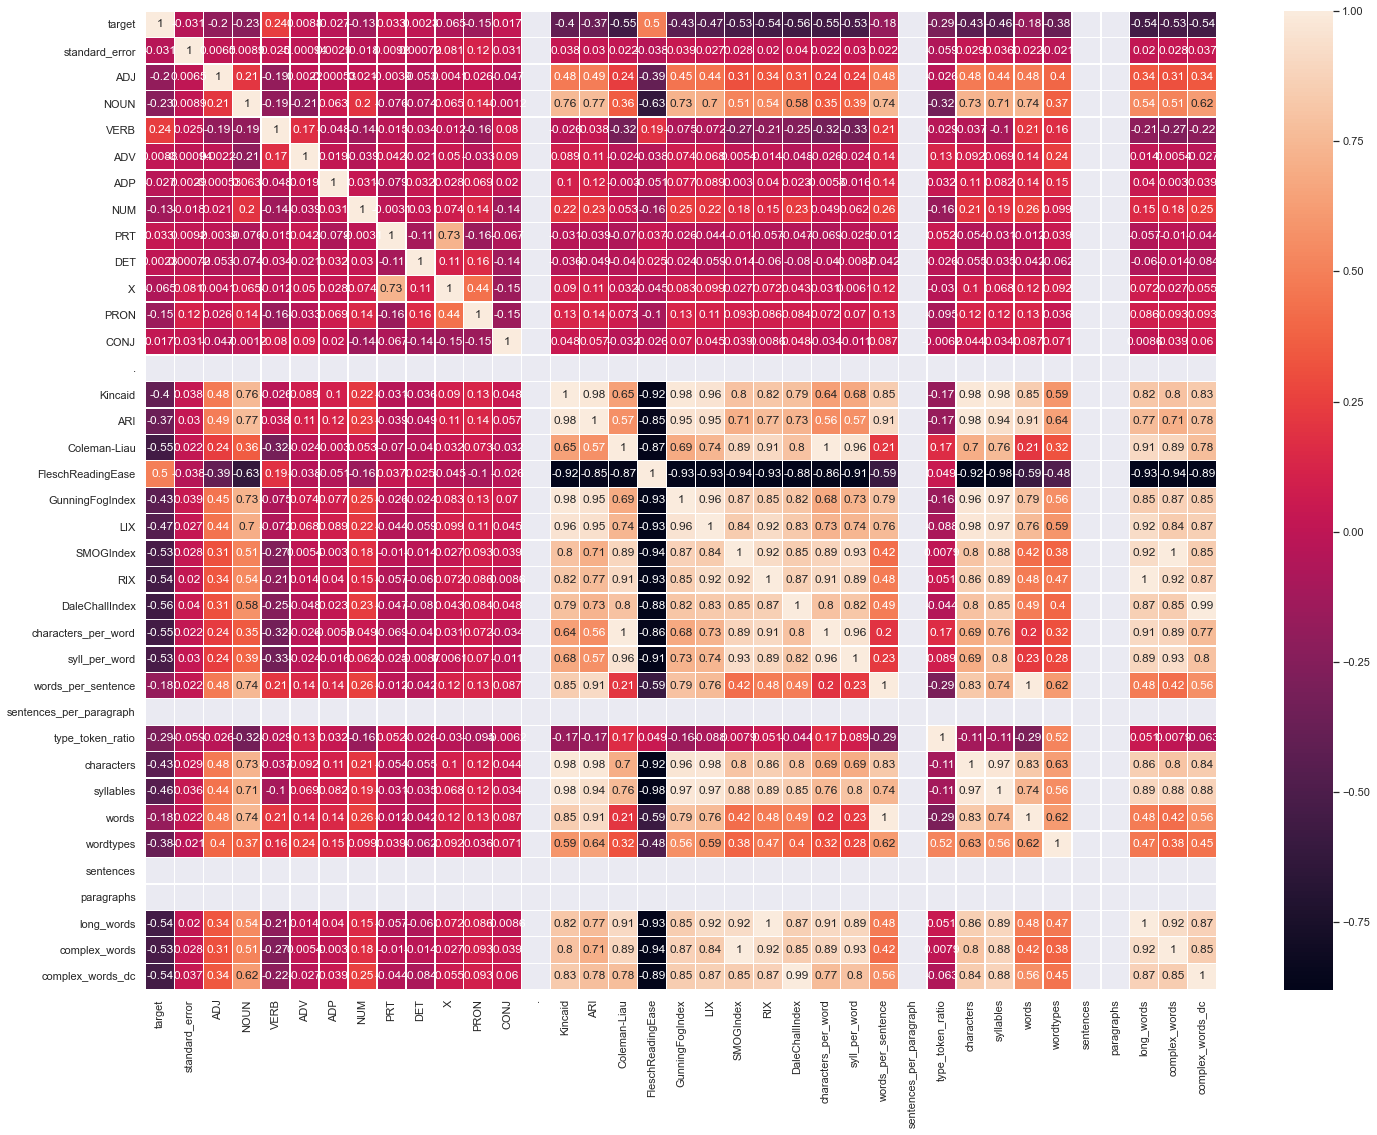

In [6]:
# Spearman correlation heatmap (needs to be refined)
f, ax = plt.subplots(figsize=(24,18))
sns.heatmap(feat_df.corr(method='spearman'), annot=True, linewidth=.3, ax=ax, yticklabels=True, robust=True)
plt.savefig('feat_heatmap.JPG')
plt.show()

In [7]:
# plot vars with correlations with target above abs(35)

target = feat_df['target']

feat_df['target'].corr(feat_df['GunningFogIndex'])

-0.4333394674564036

In [55]:
# plot

corr_dict = {}

for i in feat_df.columns:
    if i in {'target', 'id', 'url_legal', 'license'}:
        pass
    else:
        correlation = target.corr(feat_df[i], method='spearman')
        
        if abs(correlation) > .35:
            corr_dict[i] = correlation
            
corr_dict

{'Kincaid': -0.3990710967870545,
 'ARI': -0.3651401430202506,
 'Coleman-Liau': -0.5535197517756388,
 'FleschReadingEase': 0.500564386246633,
 'GunningFogIndex': -0.43314132446106196,
 'LIX': -0.4664922916522711,
 'SMOGIndex': -0.5270667452027656,
 'RIX': -0.5446159403260917,
 'DaleChallIndex': -0.5570072514096376,
 'characters_per_word': -0.5528820696826021,
 'syll_per_word': -0.5266018231101464,
 'characters': -0.43258953870790906,
 'syllables': -0.4554480741646979,
 'wordtypes': -0.37578355426393745,
 'long_words': -0.5446159403260917,
 'complex_words': -0.5270667452027656,
 'complex_words_dc': -0.5443899898457077}

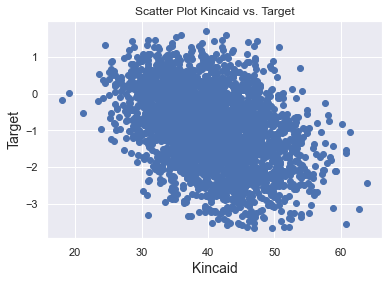

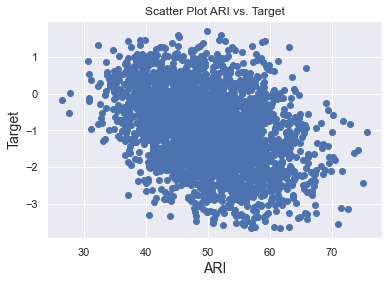

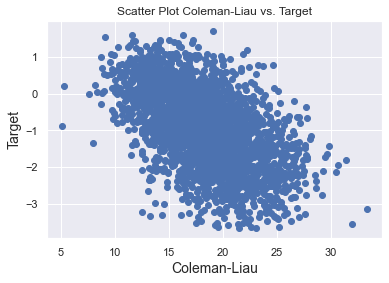

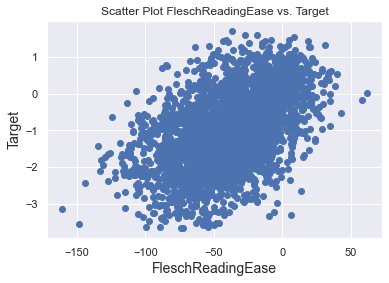

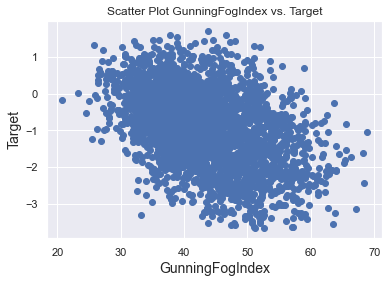

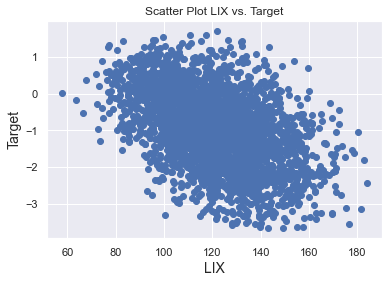

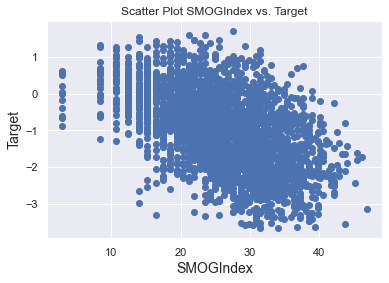

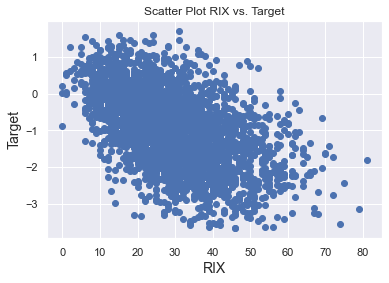

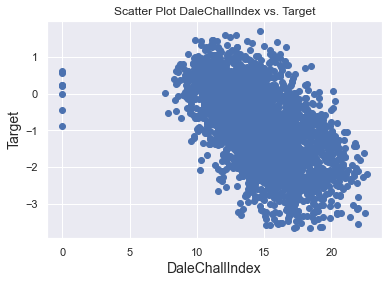

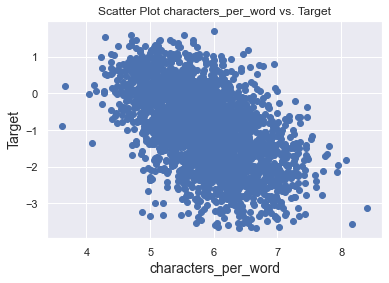

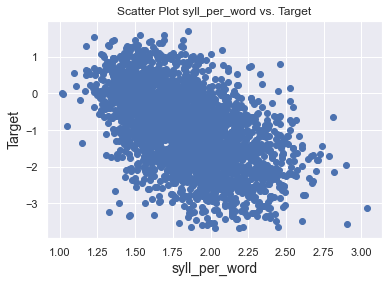

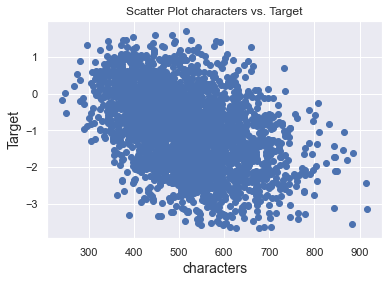

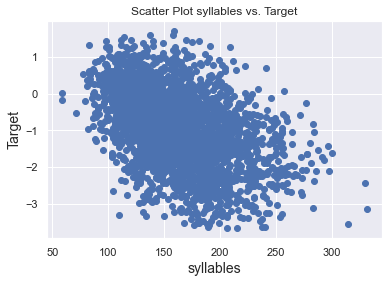

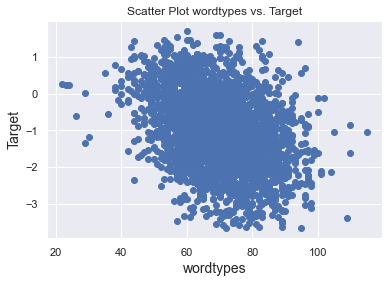

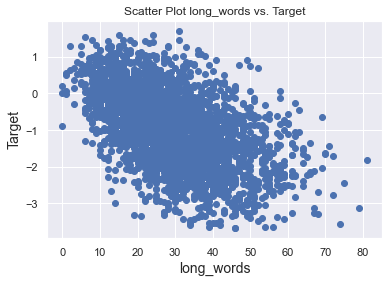

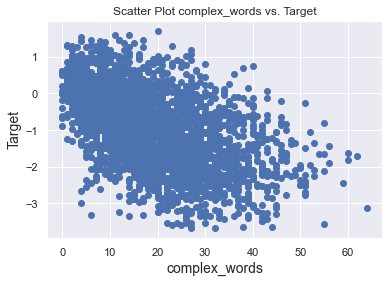

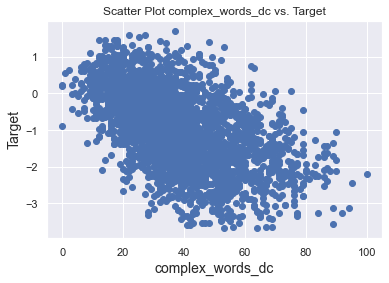

In [7]:
# the lower the target var, the more difficult the read of the excerpt (lower readability)
# vars that negatively correlate with target var means that as var goes up, target goes down, and vice versa

# Scatterplots

for i in corr_dict.keys():
    
    plt.scatter(feat_df[i], target)
    plt.title('Scatter Plot ' + i + ' vs. Target')
    plt.xlabel(i, fontsize=14)
    plt.ylabel('Target', fontsize=14)
    plt.show()

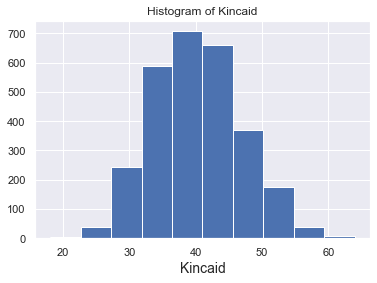

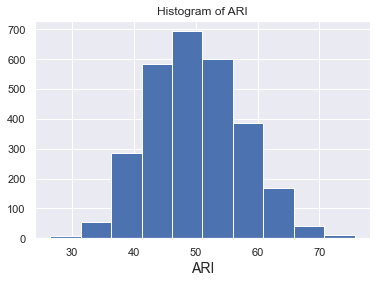

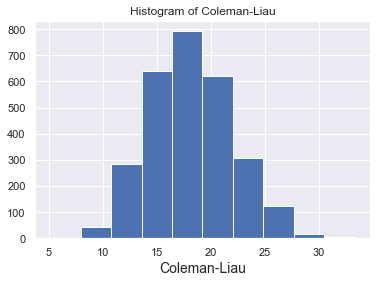

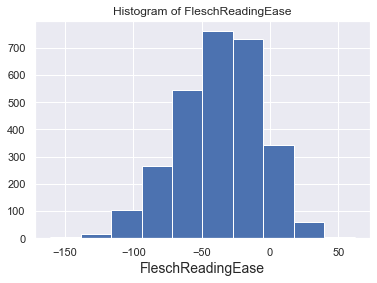

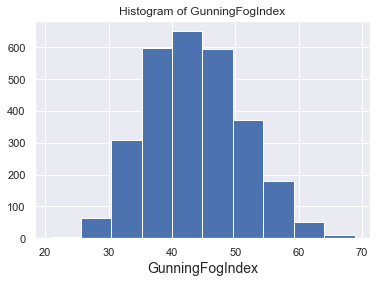

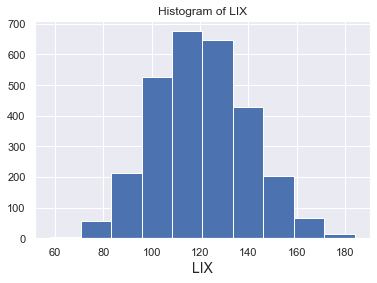

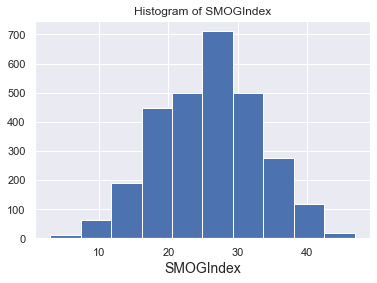

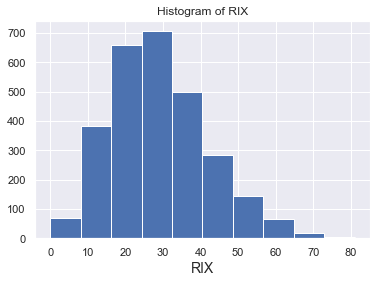

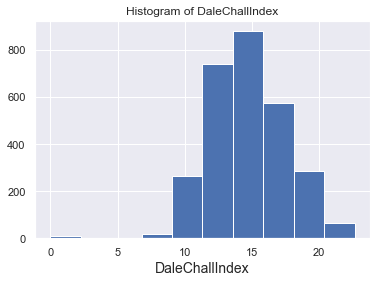

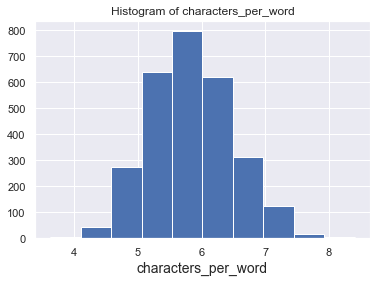

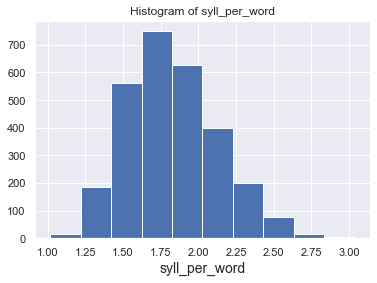

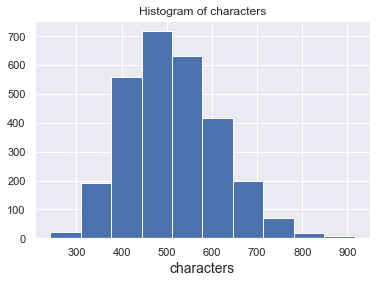

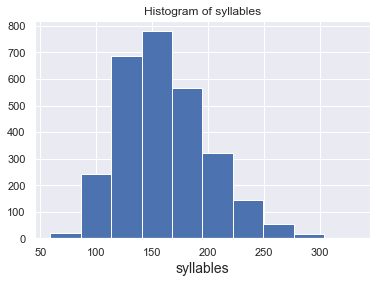

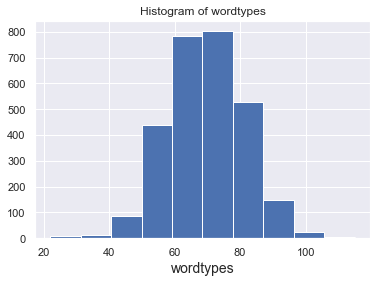

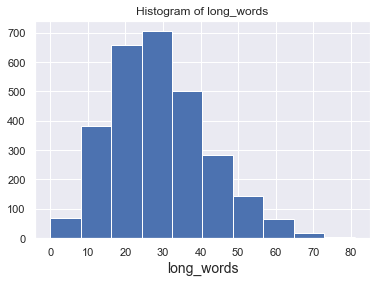

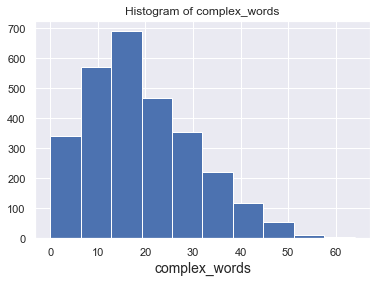

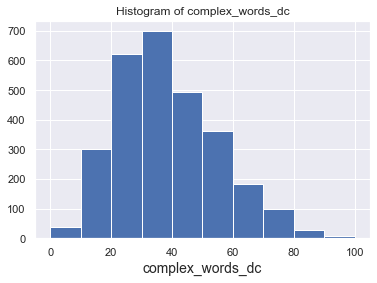

In [81]:
# histograms

for i in corr_dict.keys():
    
    feat_df[i].hist()
    plt.title('Histogram of ' + i)
    plt.xlabel(i, fontsize=14)
    plt.show()

In [28]:
# save to csv

feat_df.to_csv('feat_df.csv', index=False)

In [29]:
# TODO 

# Research Possible Machine Learning Models (Specifically Ensemble-based)
# Work Stacking Model possibilities (consider using neural network)

In [2]:
feat_df = pd.read_csv('feat_df.csv')

feat_df.head()

,id,url_legal,license,excerpt,target,standard_error,proc_ex,ADJ,NOUN,VERB,...,type_token_ratio,characters,syllables,words,wordtypes,sentences,paragraphs,long_words,complex_words,complex_words_dc
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,"['young', 'people', 'returned', 'ballroom', 'p...",16,41,19,...,0.831461,501,148,89,74,1,1,30,16,34
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,"['dinner', 'time', 'mr', 'fayre', 'somewhat', ...",20,24,25,...,0.839080,471,150,87,73,1,1,23,12,26
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,"['roger', 'predicted', 'snow', 'departed', 'qu...",18,30,18,...,0.858824,450,138,85,73,1,1,23,14,37
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,"['outside', 'palace', 'great', 'garden', 'wall...",22,46,15,...,0.868132,481,136,91,79,1,1,18,5,23
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,"['upon', 'time', 'three', 'bear', 'lived', 'to...",32,22,8,...,0.314286,340,87,70,22,1,1,6,5,6


In [5]:
test_dict = {}

test_dict[feat_df['excerpt'][0]] = feat_df['proc_ex'][0]

feat_df.loc[:, 'proc_ex':]



,proc_ex,ADJ,NOUN,VERB,ADV,ADP,NUM,PRT,DET,X,...,type_token_ratio,characters,syllables,words,wordtypes,sentences,paragraphs,long_words,complex_words,complex_words_dc
0,"['young', 'people', 'returned', 'ballroom', 'p...",16,41,19,6.0,3.0,4.0,NaN,NaN,NaN,...,0.831461,501,148,89,74,1,1,30,16,34
1,"['dinner', 'time', 'mr', 'fayre', 'somewhat', ...",20,24,25,15.0,1.0,NaN,2.0,NaN,NaN,...,0.839080,471,150,87,73,1,1,23,12,26
2,"['roger', 'predicted', 'snow', 'departed', 'qu...",18,30,18,16.0,2.0,1.0,NaN,NaN,NaN,...,0.858824,450,138,85,73,1,1,23,14,37
3,"['outside', 'palace', 'great', 'garden', 'wall...",22,46,15,4.0,1.0,3.0,NaN,NaN,NaN,...,0.868132,481,136,91,79,1,1,18,5,23
4,"['upon', 'time', 'three', 'bear', 'lived', 'to...",32,22,8,1.0,4.0,3.0,NaN,NaN,NaN,...,0.314286,340,87,70,22,1,1,6,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,"['think', 'dinosaur', 'lived', 'picture', 'see...",18,34,24,4.0,2.0,4.0,NaN,NaN,NaN,...,0.697674,516,159,86,60,1,1,31,20,37
2830,"['solid', 'solid', 'usually', 'hard', 'molecul...",21,33,10,13.0,3.0,1.0,NaN,NaN,NaN,...,0.691358,444,146,81,56,1,1,18,15,35
2831,"['second', 'state', 'matter', 'discus', 'liqui...",16,46,15,4.0,1.0,1.0,NaN,NaN,NaN,...,0.602410,433,134,83,50,1,1,15,10,31
2832,"['solid', 'shape', 'actually', 'touch', 'three...",17,40,11,2.0,1.0,2.0,NaN,NaN,1.0,...,0.756757,432,139,74,56,1,1,18,15,37


<AxesSubplot:>

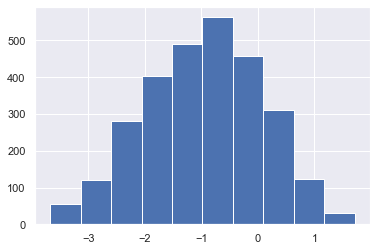

In [5]:
feat_df.target.hist()

In [6]:
# find word spread (word frequency)

from nltk.probability import FreqDist

freq_dist = pd.Series(''.join(feat_df['proc_ex'])).value_counts()

# plot word distribution

freq_dist.plot(kind='line')

<AxesSubplot:>

ValueError: Image size of 10234820x251 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 1 Axes>

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.pipeline import Pipeline

X = feat_df.loc[:, feat_df.columns != 'target']
y = feat_df.loc[:, feat_df.columns == 'target']


# split data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0,
                                                    stratify=None)

X_train

,id,url_legal,license,excerpt,standard_error,proc_ex,ADJ,NOUN,VERB,ADV,...,type_token_ratio,characters,syllables,words,wordtypes,sentences,paragraphs,long_words,complex_words,complex_words_dc
1110,87f96eb79,NaN,NaN,But that hadn't helped Washington.\nThe Americ...,0.466193,"['nt', 'helped', 'washington', 'american', 'bl...",21,30,28,9.0,...,0.829787,537,167,94,78,1,1,24,18,34
1009,112f57fc9,http://ukuqonda.co.za/digicom/Grade-10-Technic...,CC BY 4.0,The candle clock was used years ago to indicat...,0.496087,"['candle', 'clock', 'used', 'year', 'ago', 'in...",22,46,25,6.0,...,0.631068,554,155,103,65,1,1,20,12,31
2308,6fc0df6aa,NaN,NaN,"Well, one rainy Sunday evening, in 1855, just ...",0.516423,"['well', 'one', 'rainy', 'sunday', 'evening', ...",15,30,21,8.0,...,0.886076,441,125,79,70,1,1,19,8,26
2710,130249280,NaN,NaN,"There has lately been held, at No. 31 Lombard ...",0.520748,"['lately', 'held', '31', 'lombard', 'street', ...",21,34,14,4.0,...,0.891566,504,158,83,74,1,1,39,25,51
1190,d79a4e1a5,NaN,NaN,The home I had come to as vicar was in a littl...,0.510880,"['home', 'come', 'vicar', 'little', 'neighborh...",18,42,19,6.0,...,0.977011,583,183,87,85,1,1,40,29,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,ca8926fe5,https://kids.frontiersin.org/article/10.3389/f...,CC BY 4.0,"When we go to an art gallery, there are usuall...",0.478934,"['go', 'art', 'gallery', 'usually', 'detail', ...",19,35,26,6.0,...,0.677778,570,176,90,61,1,1,44,21,44
835,ef60b30c3,https://www.africanstorybook.org/#,CC BY 4.0,There were four lambs living in a house with t...,0.476720,"['four', 'lamb', 'living', 'house', 'mother', ...",21,53,20,3.0,...,0.475248,496,148,101,48,1,1,12,7,15
1653,23ff6b3c9,NaN,NaN,I do not presume that all people over three sc...,0.494736,"['presume', 'people', 'three', 'score', 'year'...",9,32,20,7.0,...,0.868421,415,119,76,66,1,1,19,10,21
2607,91e87e7dc,NaN,NaN,Hans stopped snoring and awoke at supper-time....,0.492731,"['han', 'stopped', 'snoring', 'awoke', 'supper...",20,32,26,8.0,...,0.806818,457,141,88,71,1,1,25,10,26


In [9]:
feat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2834 entries, 0 to 2833
Data columns (total 42 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       2834 non-null   object 
 1   url_legal                830 non-null    object 
 2   license                  830 non-null    object 
 3   excerpt                  2834 non-null   object 
 4   target                   2834 non-null   float64
 5   standard_error           2834 non-null   float64
 6   proc_ex                  2834 non-null   object 
 7   ADJ                      2834 non-null   int64  
 8   NOUN                     2834 non-null   int64  
 9   VERB                     2834 non-null   int64  
 10  ADV                      2812 non-null   float64
 11  ADP                      2327 non-null   float64
 12  NUM                      2075 non-null   float64
 13  PRT                      231 non-null    float64
 14  DET                     

## Bag of Words

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

c_vector = CountVectorizer(stop_words='english', 
                           ngram_range=(1,2)) # unigrams & bigrams

# fit & transform training data 
X_train_dtm = c_vector.fit_transform([''.join(text) for text in X_train['proc_ex']])

#X = c_vector.fit_transform([' '.join(tweet) for tweet in x])
X_train_dtm

<2125x166151 sparse matrix of type '<class 'numpy.int64'>'
	with 284683 stored elements in Compressed Sparse Row format>

In [11]:
# fit & transform testing data 
X_test_dtm = c_vector.fit_transform([''.join(text) for text in X_test['proc_ex']])

#X = c_vector.fit_transform([' '.join(tweet) for tweet in x])
X_test_dtm

<709x62171 sparse matrix of type '<class 'numpy.int64'>'
	with 95163 stored elements in Compressed Sparse Row format>

In [12]:
c_vector.get_feature_names()

['002',
 '002 inch',
 '003c',
 '003c century',
 '004',
 '004 percent',
 '006f',
 '006f 003c',
 '01',
 '01 intruding',
 '01 world',
 '015',
 '015 46',
 '03',
 '03 electricity',
 '05',
 '05 deforestation',
 '074',
 '074 133',
 '0v',
 '0v point',
 '10',
 '10 15',
 '10 20',
 '10 billion',
 '10 cent',
 '10 futurewave',
 '10 gigawatts',
 '10 kev',
 '10 kilometre',
 '10 meter',
 '10 year',
 '100',
 '100 bad',
 '100 cubic',
 '100 good',
 '100 mm',
 '100 time',
 '1000',
 '1000 horsepower',
 '100000',
 '100000 light',
 '100000 square',
 '100000 worker',
 '100000 year',
 '10000000',
 '10000000 year',
 '1000000000',
 '1000000000 placed',
 '100200',
 '100200 year',
 '1012',
 '1012 km',
 '1012 mi',
 '1012 number',
 '1012 pushed',
 '106',
 '106 hour',
 '1095',
 '1095 1291',
 '11',
 '11 issue',
 '11 night',
 '11000000',
 '11000000 volt',
 '111780',
 '111780 mile',
 '112',
 '112 cell',
 '112 help',
 '115',
 '115 million',
 '11th',
 '11th century',
 '12',
 '12 13',
 '12 13yearold',
 '12 60',
 '12 colony

In [12]:
import scipy as sp

X_stack = sp.sparse.hstack((X_train_dtm, X_train[corr_dict.keys()].values),format='csr')

X_columns = c_vector.get_feature_names()+X_train[corr_dict.keys()].columns.tolist()

X_stack_train = X_stack.toarray()

X_stack_train

array([[ 0.,  0.,  0., ..., 24., 18., 34.],
       [ 0.,  0.,  0., ..., 20., 12., 31.],
       [ 0.,  0.,  0., ..., 19.,  8., 26.],
       ...,
       [ 0.,  0.,  0., ..., 19., 10., 21.],
       [ 0.,  0.,  0., ..., 25., 10., 26.],
       [ 0.,  0.,  0., ..., 32., 26., 41.]])

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

regression = LinearRegression()

regression.fit(X_stack_train, y_train)

LinearRegression()

In [15]:
pred = regression.predict(X_test)

mean_squared_error(y_test, pred, squared=False)

ValueError: could not convert string to float: 'ee3057687'

## TFIDF Vectorization

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer as tfi
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Ridge

vectorizer = tfi(min_df=3)

X_tfidf = vectorizer.fit_transform(X_train['proc_ex']) # training text data
X_test_tfidf = vectorizer.transform(X_test['proc_ex']) # validating text data

X_train.fillna('nan',inplace=True)
X_train.isnull().sum()

C:\Users\mvela\anaconda3\lib\site-packages\pandas\core\frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


id                         0
url_legal                  0
license                    0
excerpt                    0
standard_error             0
proc_ex                    0
ADJ                        0
NOUN                       0
VERB                       0
ADV                        0
ADP                        0
NUM                        0
PRT                        0
DET                        0
X                          0
PRON                       0
CONJ                       0
.                          0
Kincaid                    0
ARI                        0
Coleman-Liau               0
FleschReadingEase          0
GunningFogIndex            0
LIX                        0
SMOGIndex                  0
RIX                        0
DaleChallIndex             0
characters_per_word        0
syll_per_word              0
words_per_sentence         0
sentences_per_paragraph    0
type_token_ratio           0
characters                 0
syllables                  0
words         

In [56]:
# corr dict function

def gen_features(corr_thresh):
    corr_dict = {}

    for i in feat_df.columns:
        if i in {'target', 'id', 'url_legal', 'license'}:
            pass
        else:
            correlation = target.corr(feat_df[i], method='spearman')

            if abs(correlation) > corr_thresh:
                corr_dict[i] = correlation
            
    return corr_dict

In [17]:
X_train[corr_dict.keys()]

,Kincaid,ARI,Coleman-Liau,FleschReadingEase,GunningFogIndex,LIX,SMOGIndex,RIX,DaleChallIndex,characters_per_word,syll_per_word,characters,syllables,wordtypes,long_words,complex_words,complex_words_dc
1110,42.033830,52.477128,17.474650,-38.875000,45.259574,119.531915,26.237900,24.0,14.010177,5.712766,1.776596,537,167,78,24,18,34
1009,42.337282,55.403398,15.537547,-25.020680,45.860194,122.417476,21.973666,20.0,13.497630,5.378641,1.504854,554,155,65,20,12,31
2308,33.890886,44.362532,16.647639,-7.210759,35.650633,103.050633,18.491933,19.0,12.751609,5.582278,1.582278,441,125,70,19,8,26
2710,39.242651,48.670482,19.546878,-38.455783,45.248193,129.987952,30.386128,39.0,17.455589,6.072289,1.903614,504,158,74,39,25,51
1190,43.160690,53.632414,23.260872,-59.421724,48.133333,132.977011,32.495762,40.0,16.300436,6.701149,2.103448,583,183,85,40,29,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,42.585556,53.400000,21.109505,-49.955000,45.333333,138.888889,28.099801,44.0,15.820056,6.333333,1.955556,570,176,61,44,21,44
835,41.091089,52.200297,12.781561,-19.648317,43.172277,112.881188,17.491377,12.0,10.991150,4.910891,1.465347,496,148,48,12,7,15
1653,32.526316,42.289079,15.916971,-2.770789,35.663158,101.000000,20.320508,19.0,11.769126,5.460526,1.565789,415,119,66,19,10,21
2607,37.636818,47.029886,14.398112,-18.037273,39.745455,116.409091,20.320508,25.0,12.666527,5.193182,1.602273,457,141,71,25,10,26


In [18]:
X_test[corr_dict.keys()]

,Kincaid,ARI,Coleman-Liau,FleschReadingEase,GunningFogIndex,LIX,SMOGIndex,RIX,DaleChallIndex,characters_per_word,syll_per_word,characters,syllables,wordtypes,long_words,complex_words,complex_words_dc
981,35.958025,45.120370,16.354578,-18.468889,37.832099,110.629630,21.165902,24.0,12.917433,5.530864,1.691358,448,137,69,24,11,27
683,49.931538,59.916923,20.550698,-77.686538,51.600000,141.500000,30.928480,39.0,18.359996,6.230769,2.115385,648,220,75,39,26,63
195,37.681798,48.101798,15.115850,-16.578652,41.442697,115.966292,22.748418,24.0,13.373372,5.314607,1.573034,473,140,67,24,13,30
1158,40.390000,49.832625,22.856866,-52.025000,45.000000,130.000000,30.928480,40.0,16.881125,6.637500,2.100000,531,168,76,40,26,47
1553,42.617755,54.868776,17.976421,-35.937041,44.914286,130.653061,23.493902,32.0,13.975463,5.795918,1.693878,568,166,86,32,14,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,36.107816,46.865172,14.812811,-8.856207,35.719540,101.942529,10.745967,13.0,12.126068,5.264368,1.505747,458,131,66,13,2,23
1180,33.900000,44.239500,15.874543,-5.495000,37.000000,105.000000,20.320508,20.0,11.157250,5.450000,1.550000,436,124,71,20,10,18
2708,33.209855,40.374348,17.856488,-20.139130,36.875362,103.782609,24.908902,24.0,15.297161,5.797101,1.855072,400,128,61,24,16,36
1683,55.527826,67.196957,22.800061,-98.216957,59.565217,170.652174,37.205263,64.0,21.148674,6.608696,2.226087,760,256,98,64,39,86


In [13]:
X_train_stack = sp.sparse.hstack((X_tfidf, X_train[corr_dict.keys()].values))
X_test_stack = sp.sparse.hstack((X_test_tfidf, X_test[corr_dict.keys()].values))
# fit ridge regression

clf = Ridge(alpha=1.0, random_state=0)

# target

#X_train_stack = X_train_stack.reshape(-1,1)
clf.fit(X_train_stack, y_train)

Ridge(random_state=0)

In [20]:
X_train[corr_dict.keys()].shape
X_train_stack.reshape(-1,1).shape
#X_test_stack.reshape(-1,1).shape

(15559250, 1)

In [21]:
result = clf.predict(X_test_stack)

result

array([[ 0.43041312],
       [-1.44556793],
       [-0.23757405],
       [-2.39070082],
       [-1.12294866],
       [-1.53789861],
       [ 0.53882843],
       [-0.61205511],
       [-1.35507456],
       [-1.05481253],
       [-1.64553779],
       [-0.11600955],
       [-0.98722119],
       [-1.17377611],
       [-1.38075022],
       [ 0.15367723],
       [-0.18486065],
       [-0.36484765],
       [-0.77491691],
       [-0.63676428],
       [-0.2327934 ],
       [-1.34738387],
       [-0.07020801],
       [-1.19151034],
       [-0.33419732],
       [-1.73699138],
       [-1.14494429],
       [-0.72851167],
       [-1.1058186 ],
       [-0.26279674],
       [-1.31983928],
       [-0.91067726],
       [ 0.84590152],
       [-1.04694608],
       [-0.58147282],
       [-1.20349335],
       [-1.20174512],
       [-0.2941276 ],
       [-1.19924068],
       [ 0.17102041],
       [-1.78389177],
       [-0.71741307],
       [-1.54215257],
       [ 0.37214453],
       [ 0.43112672],
       [-1

In [22]:
# room mean squared error of ridge reg

mean_squared_error(y_test, result, squared=False)

0.7087369538284408

In [23]:
# r2 coefficient of determination

from sklearn.metrics import r2_score

r2_score(y_test, result)

0.534660230807082

In [14]:
X.drop('id', axis=1, inplace=True)
X

C:\Users\mvela\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,url_legal,license,excerpt,standard_error,proc_ex,ADJ,NOUN,VERB,ADV,ADP,...,type_token_ratio,characters,syllables,words,wordtypes,sentences,paragraphs,long_words,complex_words,complex_words_dc
0,NaN,NaN,When the young people returned to the ballroom...,0.464009,"['young', 'people', 'returned', 'ballroom', 'p...",16,41,19,6.0,3.0,...,0.831461,501,148,89,74,1,1,30,16,34
1,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",0.480805,"['dinner', 'time', 'mr', 'fayre', 'somewhat', ...",20,24,25,15.0,1.0,...,0.839080,471,150,87,73,1,1,23,12,26
2,NaN,NaN,"As Roger had predicted, the snow departed as q...",0.476676,"['roger', 'predicted', 'snow', 'departed', 'qu...",18,30,18,16.0,2.0,...,0.858824,450,138,85,73,1,1,23,14,37
3,NaN,NaN,And outside before the palace a great garden w...,0.450007,"['outside', 'palace', 'great', 'garden', 'wall...",22,46,15,4.0,1.0,...,0.868132,481,136,91,79,1,1,18,5,23
4,NaN,NaN,Once upon a time there were Three Bears who li...,0.510845,"['upon', 'time', 'three', 'bear', 'lived', 'to...",32,22,8,1.0,4.0,...,0.314286,340,87,70,22,1,1,6,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,0.646900,"['think', 'dinosaur', 'lived', 'picture', 'see...",18,34,24,4.0,2.0,...,0.697674,516,159,86,60,1,1,31,20,37
2830,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,So what is a solid? Solids are usually hard be...,0.535648,"['solid', 'solid', 'usually', 'hard', 'molecul...",21,33,10,13.0,3.0,...,0.691358,444,146,81,56,1,1,18,15,35
2831,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,The second state of matter we will discuss is ...,0.483866,"['second', 'state', 'matter', 'discus', 'liqui...",16,46,15,4.0,1.0,...,0.602410,433,134,83,50,1,1,15,10,31
2832,https://en.wikibooks.org/wiki/Geometry_for_Ele...,CC BY-SA 3.0,Solids are shapes that you can actually touch....,0.514128,"['solid', 'shape', 'actually', 'touch', 'three...",17,40,11,2.0,1.0,...,0.756757,432,139,74,56,1,1,18,15,37


In [25]:
# standardize data

'''After testing fitting the model with standardized data, normalized data,
 and both, it seems neither method improves the model further than pre-processed
 data'''

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# X = feat_df.loc[:, feat_df.columns != 'target']
# y = feat_df.loc[:, feat_df.columns == 'target']

# scaled_x_train = StandardScaler().fit_transform(X_train[corr_dict.keys()])
# scaled_x_test = StandardScaler().fit_transform(X_test[corr_dict.keys()])

norm_x_train = MinMaxScaler().fit_transform(X_train[corr_dict.keys()])
norm_x_test = MinMaxScaler().fit_transform(X_test[corr_dict.keys()])
#scaled_y = StandardScaler().fit_transform(y_train)
#scaled_text = Standard




# split data

#X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(scaled_x, scaled_y, test_size=.25, random_state=0)

# prepare scaled matrix

X_s_train_stack = sp.sparse.hstack((X_tfidf, norm_x_train))
X_s_test_stack = sp.sparse.hstack((X_test_tfidf, norm_x_test))

# fit ridge regression

clf_scaled = Ridge(alpha=1.0, random_state=0)

# target

#X_train_stack = X_train_stack.reshape(-1,1)
clf_scaled.fit(X_s_train_stack, y_train)

Ridge(random_state=0)

In [26]:
# get predictions

preds = clf_scaled.predict(X_s_test_stack)

# room mean squared error of ridge reg

print(mean_squared_error(y_test, preds, squared=False))

# r2 coefficient of determination

print(r2_score(y_test, preds))

0.7139916219006412
0.527734472096162


In [50]:
preds.reshape(-1,1)

array([[ 0.82038925],
       [-1.57543703],
       [-0.10287787],
       [-2.65038075],
       [-1.52539522],
       [-1.19754667],
       [ 0.69189309],
       [-0.40093597],
       [-1.2723398 ],
       [-0.92490619],
       [-2.11601966],
       [-0.28376943],
       [-0.8405077 ],
       [-1.25218381],
       [-1.11637768],
       [ 0.0567325 ],
       [-0.14318703],
       [-0.37828602],
       [-0.97712889],
       [-0.532859  ],
       [-0.26093118],
       [-1.1028177 ],
       [ 0.03058526],
       [-1.1029152 ],
       [-0.51529714],
       [-1.72955478],
       [-1.00339673],
       [-0.44758073],
       [-1.27691151],
       [-0.05117133],
       [-1.66334497],
       [-0.78405393],
       [ 0.95915409],
       [-0.88137688],
       [-0.7561443 ],
       [-1.28771211],
       [-1.10729407],
       [-0.24587894],
       [-0.74271956],
       [ 0.17105628],
       [-1.73892988],
       [-0.69027247],
       [-1.55713241],
       [ 0.48087438],
       [ 0.38583603],
       [-1

In [27]:
# compare to results of original Ridge

# room mean squared error of ridge reg

print(mean_squared_error(y_test, result, squared=False))

# r2 coefficient of determination

print(r2_score(y_test, result))

0.7087369538284408
0.534660230807082


In [28]:
# use ridgecv to find best fitting model for data

from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold

# define model evaluation method

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=0)

#define model

ridge_cv_model = RidgeCV(alphas=np.arange(0,1,0.01), cv=cv, scoring='r2')

# fit model

ridge_cv_model.fit(X_train_stack, y_train)

# print scoring

#ridge_cv_model.score()

RidgeCV(alphas=array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99]),
        cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=0),
        scoring='r2')

In [29]:
# get predictions

preds = ridge_cv_model.predict(X_test_stack)

# room mean squared error of ridge cv reg

print(mean_squared_error(y_test, preds, squared=False))

# r2 coefficient of determination

print(r2_score(y_test, preds))

0.7088302442171616
0.5345377182589682


In [30]:
# Lasso model

from sklearn.linear_model import Lasso

lasso = Lasso(random_state=0, alpha=.1, max_iter=1200)

lasso.fit(X_train_stack, y_train)

preds = lasso.predict(X_test_stack)

# room mean squared error of lasso reg

print(mean_squared_error(y_test, preds, squared=False))

# r2 coefficient of determination

print(r2_score(y_test, preds))

0.8047514718700406
0.40003823489464585


In [31]:
# randomforest regressor model

from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()

rfr.fit(X_train_stack, y_train.values.ravel())

preds = rfr.predict(X_test_stack)

# room mean squared error of random forest reg

print(mean_squared_error(y_test, preds, squared=False))

# r2 coefficient of determination

print(r2_score(y_test, preds))

0.7605394012977167
0.46414973257801273


In [32]:
print('Ridge Regression CV Training R2:', ridge_cv_model.score(X_train_stack, y_train))
print('Ridge Regression CV Validation R2:', ridge_cv_model.score(X_test_stack, y_test))
print('Ridge Regression Training R2:', clf.score(X_train_stack, y_train))
print('Ridge Regression Validation R2:', clf.score(X_test_stack, y_test))
print('Random Forest Regressor Training R2:', rfr.score(X_train_stack, y_train))
print('Random Forest Regressor Validation R2:', rfr.score(X_test_stack, y_test))

Ridge Regression CV Training R2: 0.8496650099840241
Ridge Regression CV Validation R2: 0.5345377182589682
Ridge Regression Training R2: 0.8485716405066641
Ridge Regression Validation R2: 0.534660230807082
Random Forest Regressor Training R2: 0.9247358348259689
Random Forest Regressor Validation R2: 0.46414973257801273


In [33]:
# try knn, support vector machines, stacking classifier

from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()

knn.fit(X_train_stack, y_train.values.ravel())

preds = knn.predict(X_test_stack)

# room mean squared error of knn reg

print(mean_squared_error(y_test, preds, squared=False))

# r2 coefficient of determination

print(r2_score(y_test, preds))

0.8799145893165019
0.28273266706904066


In [40]:
from sklearn.svm import SVR

svm = SVR(kernel='linear')

svm.fit(X_train_stack, y_train.values.ravel())

preds = svm.predict(X_test_stack)

# room mean squared error of ridge reg

print(mean_squared_error(y_test, preds, squared=False))

# r2 coefficient of determination

print(r2_score(y_test, preds))

0.7476823216028653
0.4821139185481693


In [38]:
# Bayesian Ridge Regression

from sklearn.linear_model import BayesianRidge

bay = BayesianRidge()

bay.fit(X_train_stack.toarray(), y_train.values.ravel())

preds = bay.predict(X_test_stack)

# room mean squared error of bay ridge reg

print(mean_squared_error(y_test, preds, squared=False))

# r2 coefficient of determination

print(r2_score(y_test, preds))

0.71191500574292
0.5304776080429555


In [39]:
# ARDRegression

from sklearn.linear_model import ARDRegression

ard = ARDRegression()

ard.fit(X_train_stack.toarray(), y_train.values.ravel())

preds = ard.predict(X_test_stack)

# room mean squared error of ridge reg

print(mean_squared_error(y_test, preds, squared=False))

# r2 coefficient of determination

print(r2_score(y_test, preds))

0.9830893821042915
0.10466404385628392


In [28]:
# stacking model

from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, BayesianRidge


def stacking():
    
    # define base
    base_learners = []
    base_learners.append(('bayes', BayesianRidge()))
    base_learners.append(('svm', SVR(kernel='rbf')))
    base_learners.append(('random forest', RandomForestRegressor()))
    
    # define meta
    meta = Ridge()
    
    model = StackingRegressor(estimators=base_learners,
                              final_estimator=meta,
                              cv=5)
    
    return model


stack_model = stacking()

stack_model.fit(X_train_stack.toarray(), y_train.values.ravel())

StackingRegressor(cv=5,
                  estimators=[('bayes', BayesianRidge()), ('svm', SVR()),
                              ('random forest', RandomForestRegressor())],
                  final_estimator=Ridge())

In [32]:
# get average scoring metrics

rmse = []
train_r2 = []
val_r2 = []
stack_preds = stack_model.predict(X_test_stack.toarray())

for i in range(0, 100):
    rmse.append(mean_squared_error(y_test, stack_preds, squared=False))
    train_r2.append(stack_model.score(X_train_stack.toarray(), y_train))
    val_r2.append(stack_model.score(X_test_stack.toarray(), y_test))

# room mean squared error of stack model

print('Average Stack Model RMSE:', np.mean(rmse))
print('Average Stack Model Training R2:', np.mean(train_r2))
print('Average Stack Model Validation R2:', np.mean(val_r2))

Average Stack Model RMSE: 0.7036150175865482
Average Stack Model Training R2: 0.9494034847400883
Average Stack Model Validation R2: 0.5413618095263913


In [9]:
!python --version

Python 3.8.10


In [34]:
np.mean(rmse)

0.7036150175865482

In [37]:
# try boosting models

#!pip install xgboost

import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor

In [40]:
# xgboost model

xg_model = xgb.XGBRegressor()

xg_model.fit(X_train_stack.toarray(), y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [47]:
# grad boosting model

grad_model = GradientBoostingRegressor()

grad_model.fit(X_train_stack.toarray(), y_train.values.ravel())

GradientBoostingRegressor()

In [49]:
# ada boosting model

ada_model = AdaBoostRegressor()

ada_model.fit(X_train_stack.toarray(), y_train.values.ravel())

AdaBoostRegressor()

In [50]:
# Boosting Model Results

xg_preds = xg_model.predict(X_test_stack.toarray())
grad_preds = grad_model.predict(X_test_stack.toarray())
ada_preds = ada_model.predict(X_test_stack.toarray())

# xg
print('XG Model RMSE:', mean_squared_error(y_test, xg_preds, squared=False))
print('XG Model Training R2:', xg_model.score(X_train_stack.toarray(), y_train))
print('XG Model Validation R2:', xg_model.score(X_test_stack.toarray(), y_test))

# grad
print('Gradient Boosting Model RMsSE:', mean_squared_error(y_test, grad_preds, squared=False))
print('Gradient Boosting Model Training R2:', grad_model.score(X_train_stack.toarray(), y_train))
print('Gradient Boosting Model Validation R2:', grad_model.score(X_test_stack.toarray(), y_test))

# ada
print('AdaBoost Model RMSE:', mean_squared_error(y_test, ada_preds, squared=False))
print('AdaBoost Model Training R2:', ada_model.score(X_train_stack.toarray(), y_train))
print('AdaBoost Model Validation R2:', ada_model.score(X_test_stack.toarray(), y_test))

XG Model RMSE: 0.7639024800250946
XG Model Training R2: 0.9547427422967791
XG Model Validation R2: 0.4594002322662244
Gradient Boosting Model RMSE: 0.7599209912767417
Gradient Boosting Model Training R2: 0.6631370859324743
Gradient Boosting Model Validation R2: 0.4650207997458963
AdaBoost Model RMSE: 0.8339258520843769
AdaBoost Model Training R2: 0.4392385558799181
AdaBoost Model Validation R2: 0.3557493141416149


In [59]:
# use more featues

corr_dict_2 = gen_features(.20)

corr_dict_2

# create X_train and X_test again

X_train_stack = sp.sparse.hstack((X_tfidf, X_train[corr_dict_2.keys()].values))
X_test_stack = sp.sparse.hstack((X_test_tfidf, X_test[corr_dict_2.keys()].values))

# fit ridge regression

ridge = Ridge(alpha=1.0, random_state=0)

ridge.fit(X_train_stack, y_train)

# get predictions
ridge_preds = ridge.predict(X_test_stack.toarray())

# get scores
print('Ridge Model RMSE:', mean_squared_error(y_test, ridge_preds, squared=False))
print('Ridge Model Training R2:', ridge.score(X_train_stack.toarray(), y_train))
print('Ridge Model Validation R2:', ridge.score(X_test_stack.toarray(), y_test))

Ridge Model RMSE: 0.7107992674332968
Ridge Model Training R2: 0.8496966953092739
Ridge Model Validation R2: 0.531948158899577


In [ ]:
feat_df.corr()['target'].sort_values()

In [ ]:
sns.distplot(a=feat_df.target)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer as tfi
from sklearn.preprocessing import normalize

tf_idf_vect = tfi(stop_words = 'english', max_features = 15)

corpus = [' '.join(eval(text)) for text in feat_df.proc_ex]

tf_idf = tf_idf_vect.fit_transform(corpus)

tf_idf_norm = normalize(tf_idf)

tf_array = tf_idf_norm.toarray()

tf_df = pd.DataFrame(tf_array, columns=tf_idf_vect.get_feature_names())

tf_df.head()

In [ ]:
tf_df.describe()

## Feature Selection

In [ ]:
# Creation of feature matrix
x = feat_df.drop('target', 1)

In [ ]:
# feature selection methods, imports for statsmodels

import statsmodels.api as sm
import scipy.stats 
from sklearn.linear_model import LinearRegression

def forward_selection(data, response, alpha=0.05):
    ini_feats = data.columns.tolist()
    best_feats = []
    
    while len(ini_feats) > 0:
        remaining_feats = list(set(ini_feats) - set(best_feats))
        new_pval = pd.Series(index=remaining_feats, dtype=float)
        
        for new_col in remaining_feats:
            model = sm.OLS(response, sm.add_constant(data[best_feats+[new_col]])).fit()
            new_pval[new_col] = model.pvalues[new_col]
        min_p_val = new_pval.min()
        
        if min_p_val < alpha:
            best_feats.append(new_pval.idxmin())
        else:
            break
    return best_feats, model.summary()


def backward_elimination(data, response, alpha=0.05):
    feats = data.columns.tolist()
    while len(feats) > 0:
        
        feats_with_constant = sm.add_constant(data[feats])
        p_vals = sm.OLS(response, feats_with_constant).fit().pvalues[1:]
        model = sm.OLS(response, feats_with_constant).fit()
        max_p_val = p_vals.max()
        
        if max_p_val >= alpha:
            excluded_feat = p_vals.idxmax()
            feats.remove(excluded_feat)
        else:
            break
    return feats, model.summary()


def stepwise_selection(data, response, alpha_in=0.05, alpha_out=0.05):
    ini_feats = data.columns.tolist()
    best_feats = []
    while len(ini_feats) > 0:
        
        remaining_feats = list(set(ini_feats) - set(best_feats))
        new_pval = pd.Series(index=remaining_feats)
        
        for new_col in remaining_feats:
            model = sm.OLS(response, sm.add_constant(data[best_feats+[new_col]])).fit()
            new_pval[new_col] = model.pvalues[new_col]
        min_p_val = new_pval.min()
        
        if min_p_val < alpha_in:
            best_feats.append(new_pval.idxmin())
            
            while len(best_feats) > 0:
                best_feats_with_constant = sm.add_constant(data[best_feats])
                p_vals = sm.OLS(response, best_feats_with_constant).fit().pvalues[1:]
                max_p_val = p_vals.max()
                
                if max_p_val >= alpha_out:
                    excluded_feat = p_vals.idxmax()
                    best_feats.remove(excluded_feat)
                else:
                    break
        else:
            break
    return best_feats, model.summary()

In [ ]:
# forward selection

new_df = feat_df[corr_dict.keys()]

#x = x.fillna(0)

forward_selection(new_df, target)

In [ ]:
backward_elimination(new_df, target)

In [ ]:
stepwise_selection(new_df, target)

In [ ]:
x